# Bank Term Deposit Classification

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Metrics
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, make_scorer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

# Class imbalance
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE


## Load Data

In [2]:
# Load the dataset
df = pd.read_csv('data/bank_term_deposit/bank_term_deposit_prepared.csv')
df.head()

,id,split,age,education,default,balance,housing,loan,day,duration,...,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown,season_spring,season_summer,season_winter,age_group,balance_group
0,1,labeled,31,3.0,0,460,0,0,28,13,...,0,0,0,0,1,0,1,0,1,2
1,2,labeled,34,2.0,0,1826,1,0,20,203,...,0,1,0,0,1,1,0,0,1,3
2,3,labeled,50,2.0,0,290,1,0,7,226,...,0,0,0,0,1,0,1,0,3,2
3,4,labeled,42,2.0,0,1077,1,0,14,213,...,0,1,0,0,1,1,0,0,2,3
4,5,labeled,47,2.0,0,41,1,0,5,298,...,0,0,0,0,1,1,0,0,3,2


In [3]:
df.shape

(3063, 49)

## Split Column

In [4]:
leaderboard_df = df[df['split'] == 'leaderboard'].copy()
df = df[df['split'] == 'labeled']

In [5]:
df['y'].value_counts()

y
0    1833
1     174
Name: count, dtype: int64

## Functions

In [6]:
def rs_cv_results(rs, n_best=5): 
    # Get the indices of the smallest Bacc values
    best_indices = np.argsort(rs.cv_results_['mean_test_Bacc'])[-n_best:]

    # Show best Baccs and their corresponding hyperparams.
    for i in best_indices[::-1]:
        print('Bacc:', rs.cv_results_['mean_test_Bacc'][i].round(2))
        print('Hyperparams:', rs.cv_results_['params'][i])
        print()

In [7]:
def create_submission(model, X, y, leaderboard_df, fts2drop, decision_th=None, fpath=''):
    X_lb = leaderboard_df.drop(columns=fts2drop)
    model.fit(X, y)
    if decision_th is None:
        preds = model.predict(X_lb)
    else:
        y_prob1 = model.predict_proba(X_lb)[:, 1]
        preds = (y_prob1 >= decision_th).astype(int)
    submission_df = pd.DataFrame({
        'id': leaderboard_df['id'],
        'prediction': preds
    })
    if not fpath:
        fpath = 'house_pricing_submission.csv'
    submission_df.to_csv(fpath, index=False)

## Train / Test

In [8]:
target_col = 'y'
fts2drop = ['id', 'split', target_col]

In [ ]:
X = df.drop(columns=fts2drop)
y = df[target_col]

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2, random_state=42)

## Cross-validation

In [10]:
# Declare KFold
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Declare scores to be used
scoring = {
    'Bacc': make_scorer(balanced_accuracy_score),
    'Prec': make_scorer(precision_score, zero_division=0),
    'Rec': make_scorer(recall_score)
}

In [11]:
def print_metrics(cv_results):
    for sc in scoring.keys():
        print(f'Train {sc}:', cv_results[f'train_{sc}'].mean().round(3))
    print()
    for sc in scoring.keys():
        print(f'Validation {sc}:', cv_results[f'test_{sc}'].mean().round(3))
        
def print_metrics_rs(rand_search, idx=None):
    if idx is None:
        idx = rand_search.best_index_
    for sc in scoring.keys():
        print(f'Train {sc}:', rand_search.cv_results_[f'mean_train_{sc}'][idx].round(3))
    print()
    for sc in scoring.keys():
        print(f'Validation {sc}:', rand_search.cv_results_[f'mean_test_{sc}'][idx].round(3))

## Models

### Baseline 1

Doing something like this is not very informative...

In [12]:
from sklearn.dummy import DummyClassifier

In [13]:
bl1 = DummyClassifier(strategy='most_frequent')
bl1_cv = cross_validate(bl1, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(bl1_cv)

Train Bacc: 0.5
Train Prec: 0.0
Train Rec: 0.0

Validation Bacc: 0.5
Validation Prec: 0.0
Validation Rec: 0.0


In [14]:
bl1 = DummyClassifier(strategy='stratified')
bl1_cv = cross_validate(bl1, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(bl1_cv)

Train Bacc: 0.496
Train Prec: 0.079
Train Rec: 0.081

Validation Bacc: 0.504
Validation Prec: 0.097
Validation Rec: 0.093


### Baseline 2

In [15]:
bl2 = LogisticRegression(max_iter=10_000)
bl2_cv = cross_validate(bl2, X_train[['duration']], y_train, cv=kf,
                        scoring=scoring, return_train_score=True)

print_metrics(bl2_cv)

Train Bacc: 0.712
Train Prec: 0.82
Train Rec: 0.432

Validation Bacc: 0.712
Validation Prec: 0.821
Validation Rec: 0.433


### Logistic Regression

In [26]:
lr = Pipeline([
    ('scaler', None),
    ('lr', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=100_000, n_jobs=-1))
])

params = [{
    'scaler': [MinMaxScaler(), RobustScaler(), StandardScaler()],
    'lr__C': np.logspace(-3, 2, 20),
    'lr__l1_ratio': np.arange(0, 1.01, 0.1),
    'lr__class_weight': [
        'balanced',
        None,
        {0:1, 1:2},
        {0:1, 1:3},
        {0:1, 1:5},
        {0:1, 1:10},
    ],
}]

lr_rs = RandomizedSearchCV(lr,
                           param_distributions=params,
                           n_iter=50,
                           scoring=scoring,
                           cv=kf,
                           refit='Bacc',
                           return_train_score=True,
                           verbose=2,
                           n_jobs=-1)

lr_rs.fit(X_train, y_train)

print(lr_rs.best_params_)
print()
print_metrics_rs(lr_rs)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END lr__C=100.0, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time=   0.8s
[CV] END lr__C=100.0, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time=   0.8s
[CV] END lr__C=100.0, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time=   0.8s
[CV] END lr__C=100.0, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time=   1.0s
[CV] END lr__C=100.0, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time=   1.0s
[CV] END lr__C=100.0, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time=   1.1s
[CV] END lr__C=100.0, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time=   0.6s
[CV] END lr__C=100.0, lr__c

/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.12742749857031335, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time= 2.4min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.12742749857031335, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time= 2.4min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.12742749857031335, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time= 2.5min
[CV] END lr__C=0.12742749857031335, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time= 2.5min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.12742749857031335, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time= 2.5min
[CV] END lr__C=0.12742749857031335, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time= 2.5min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.12742749857031335, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time= 2.5min
[CV] END lr__C=0.12742749857031335, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time= 2.5min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.12742749857031335, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time= 2.5min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.12742749857031335, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time= 2.5min
[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 3}, lr__l1_ratio=0.30000000000000004, scaler=RobustScaler(); total time=   6.1s
[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 3}, lr__l1_ratio=0.30000000000000004, scaler=RobustScaler(); total time=   6.7s
[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 3}, lr__l1_ratio=0.30000000000000004, scaler=RobustScaler(); total time=   5.9s
[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 3}, lr__l1_ratio=0.30000000000000004, scaler=RobustScaler(); total time=   7.2s
[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 3}, lr__l1_ratio=0.30000000000000004, scaler=RobustScaler(); total time=   6.2s
[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 3}, lr__l1_ratio=0.30000000000000004, scaler=RobustScaler(); total time=   7.3s
[CV] END 

/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=MinMaxScaler(); total time= 2.5min
[CV] END lr__C=0.011288378916846888, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=1.0, scaler=RobustScaler(); total time=   5.0s
[CV] END lr__C=0.011288378916846888, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=1.0, scaler=RobustScaler(); total time=   4.9s
[CV] END lr__C=0.011288378916846888, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=1.0, scaler=RobustScaler(); total time=   4.8s


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=MinMaxScaler(); total time= 2.6min
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.8, scaler=MinMaxScaler(); total time=   0.1s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.8, scaler=MinMaxScaler(); total time=   0.1s
[CV] END lr__C=0.011288378916846888, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=1.0, scaler=RobustScaler(); total time=   4.9s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.8, scaler=MinMaxScaler(); total time=   0.1s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.8, scaler=MinMaxScaler(); total time=   0.1s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.8, scaler=MinMaxScaler(); total time=   0.1s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 2}, lr__l1_ratio=0.8, scaler=Min

/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=MinMaxScaler(); total time= 2.6min
[CV] END lr__C=0.011288378916846888, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=1.0, scaler=RobustScaler(); total time=   5.0s
[CV] END lr__C=0.011288378916846888, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=1.0, scaler=RobustScaler(); total time=   5.3s


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=MinMaxScaler(); total time= 2.6min
[CV] END lr__C=0.011288378916846888, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=1.0, scaler=RobustScaler(); total time=   5.0s


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=MinMaxScaler(); total time= 2.6min
[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 3}, lr__l1_ratio=1.0, scaler=MinMaxScaler(); total time=   0.7s
[CV] END lr__C=0.12742749857031335, lr__class_weight=balanced, lr__l1_ratio=0.5, scaler=RobustScaler(); total time=   4.7s
[CV] END lr__C=0.12742749857031335, lr__class_weight=balanced, lr__l1_ratio=0.5, scaler=RobustScaler(); total time=   4.8s
[CV] END lr__C=0.12742749857031335, lr__class_weight=balanced, lr__l1_ratio=0.5, scaler=RobustScaler(); total time=   4.9s
[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 3}, lr__l1_ratio=1.0, scaler=MinMaxScaler(); total time=   1.3s
[CV] END lr__C=0.12742749857031335, lr__class_weight=balanced, lr__l1_ratio=0.5, scaler=RobustScaler(); total time=   4.9s
[CV] END lr__C=0.12742749857031335, lr__class_weight=balanced, lr__l1_ratio=0.5, scaler=RobustScaler(); total time

/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=MinMaxScaler(); total time= 2.5min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.23357214690901212, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=StandardScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.23357214690901212, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=StandardScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.23357214690901212, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=StandardScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.23357214690901212, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=StandardScaler(); total time= 1.9min
[CV] END lr__C=0.23357214690901212, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=StandardScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.23357214690901212, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=StandardScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.23357214690901212, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=StandardScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.23357214690901212, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=StandardScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.23357214690901212, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=StandardScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.23357214690901212, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=StandardScaler(); total time= 2.0min
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.1, scaler=RobustScaler(); total time=   6.3s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.1, scaler=RobustScaler(); total time=   5.4s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.1, scaler=RobustScaler(); total time=   6.9s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.1, scaler=RobustScaler(); total time=   6.3s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.1, scaler=RobustScaler(); total time=   5.4s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.1, scaler=RobustScaler(); total time=   5.5s
[CV] END lr__C=0.06951927961775606, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.1, scaler=RobustScaler(); 

/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=MinMaxScaler(); total time= 2.6min
[CV] END lr__C=0.003359818286283781, lr__class_weight=balanced, lr__l1_ratio=0.8, scaler=RobustScaler(); total time=   3.9s
[CV] END lr__C=0.42813323987193913, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=MinMaxScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.42813323987193913, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=MinMaxScaler(); total time= 1.9min
[CV] END lr__C=0.003359818286283781, lr__class_weight=balanced, lr__l1_ratio=0.8, scaler=RobustScaler(); total time=   4.0s


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.42813323987193913, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=MinMaxScaler(); total time= 1.9min
[CV] END lr__C=0.42813323987193913, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=MinMaxScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.42813323987193913, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=MinMaxScaler(); total time= 1.9min
[CV] END lr__C=0.42813323987193913, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=MinMaxScaler(); total time= 1.9min
[CV] END lr__C=0.003359818286283781, lr__class_weight=balanced, lr__l1_ratio=0.8, scaler=RobustScaler(); total time=   3.8s
[CV] END lr__C=0.003359818286283781, lr__class_weight=balanced, lr__l1_ratio=0.8, scaler=RobustScaler(); total time=   4.0s
[CV] END lr__C=0.003359818286283781, lr__class_weight=balanced, lr__l1_ratio=0.8, scaler=RobustScaler(); total time=   4.0s
[CV] END lr__C=0.003359818286283781, lr__class_weight=balanced, lr__l1_ratio=0.8, scaler=RobustScaler(); total time=   4.0s
[CV] END lr__C=0.003359818286283781, lr__class_weight=balanced, lr__l1_ratio=0.8, scaler=RobustScaler(); total time=   4.0s
[CV] END lr__C=0.003359818286283781, lr__class_weight=balanced, lr__l1_ratio=0.8, scaler=RobustScaler(); total time=   4.0s


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=MinMaxScaler(); total time= 2.6min
[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.6000000000000001, scaler=RobustScaler(); total time=   7.0s
[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.6000000000000001, scaler=RobustScaler(); total time=   8.1s


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=MinMaxScaler(); total time= 2.6min
[CV] END lr__C=100.0, lr__class_weight=None, lr__l1_ratio=0.7000000000000001, scaler=RobustScaler(); total time=   6.6s
[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.6000000000000001, scaler=RobustScaler(); total time=   7.0s
[CV] END lr__C=100.0, lr__class_weight=None, lr__l1_ratio=0.7000000000000001, scaler=RobustScaler(); total time=   6.5s
[CV] END lr__C=100.0, lr__class_weight=None, lr__l1_ratio=0.7000000000000001, scaler=RobustScaler(); total time=   6.6s
[CV] END lr__C=100.0, lr__class_weight=None, lr__l1_ratio=0.7000000000000001, scaler=RobustScaler(); total time=   6.8s
[CV] END lr__C=0.7847599703514607, lr__class_weight=None, lr__l1_ratio=0.6000000000000001, scaler=StandardScaler(); total time=   0.5s
[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 5}, lr__l1_ratio=0.6000000000000001, scaler=RobustScaler(

/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.42813323987193913, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=MinMaxScaler(); total time= 1.9min
[CV] END lr__C=0.42813323987193913, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=MinMaxScaler(); total time= 1.9min
[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=RobustScaler(); total time=   7.1s
[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=RobustScaler(); total time=   7.8s
[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=RobustScaler(); total time=   6.8s
[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=RobustScaler(); total time=   6.5s
[CV] END lr__C=29.763514416313193, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.6000000000000001, scaler=RobustScaler(); total time=   6.6s
[CV] END lr__C=29.763514416313193,

/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.42813323987193913, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=MinMaxScaler(); total time= 1.9min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=0.42813323987193913, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.0, scaler=MinMaxScaler(); total time= 2.0min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=2.636650898730358, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.1, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=2.636650898730358, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.1, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=2.636650898730358, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.1, scaler=MinMaxScaler(); total time= 2.6min
[CV] END lr__C=2.636650898730358, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.1, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=2.636650898730358, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.1, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=2.636650898730358, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.1, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=2.636650898730358, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.1, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=2.636650898730358, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.1, scaler=MinMaxScaler(); total time= 2.6min
[CV] END lr__C=2.636650898730358, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.1, scaler=MinMaxScaler(); total time= 2.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=2.636650898730358, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.1, scaler=MinMaxScaler(); total time= 2.6min
[CV] END lr__C=8.858667904100823, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=RobustScaler(); total time=   7.0s
[CV] END lr__C=8.858667904100823, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=RobustScaler(); total time=   6.8s
[CV] END lr__C=8.858667904100823, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=RobustScaler(); total time=   7.6s
[CV] END lr__C=8.858667904100823, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=RobustScaler(); total time=   6.6s
[CV] END lr__C=8.858667904100823, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=RobustScaler(); total time=   6.9s
[CV] END lr__C=8.858667904100823, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.7000000000000001, scaler=RobustScaler(); total time=   8.0s
[CV] END lr__C=8.85866790410

/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=StandardScaler(); total time= 2.4min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=StandardScaler(); total time= 2.4min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=StandardScaler(); total time= 2.4min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=StandardScaler(); total time= 2.4min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=StandardScaler(); total time= 2.1min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=StandardScaler(); total time= 2.1min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=StandardScaler(); total time= 1.5min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=StandardScaler(); total time= 1.5min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=StandardScaler(); total time= 1.6min


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END lr__C=1.438449888287663, lr__class_weight={0: 1, 1: 10}, lr__l1_ratio=0.4, scaler=StandardScaler(); total time= 1.5min
{'scaler': RobustScaler(), 'lr__l1_ratio': np.float64(0.2), 'lr__class_weight': {0: 1, 1: 10}, 'lr__C': np.float64(29.763514416313193)}

Train Bacc: 0.92
Train Prec: 0.55
Train Rec: 0.91

Validation Bacc: 0.9
Validation Prec: 0.53
Validation Rec: 0.88


Exception ignored in: <function ResourceTracker.__del__ at 0x7fd6fdf85760>
Traceback (most recent call last):
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fc54eb8d760>
Traceback (most recent call last):
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7

#### Round 2

In [ ]:
rs_cv_results(lr_rs)

Bacc: 0.9
Hyperparams: {'scaler': RobustScaler(), 'lr__l1_ratio': np.float64(0.2), 'lr__class_weight': {0: 1, 1: 10}, 'lr__C': np.float64(233.57214690901213)}

Bacc: 0.9
Hyperparams: {'scaler': StandardScaler(), 'lr__l1_ratio': np.float64(0.6000000000000001), 'lr__class_weight': 'balanced', 'lr__C': np.float64(0.07847599703514611)}

Bacc: 0.89
Hyperparams: {'scaler': StandardScaler(), 'lr__l1_ratio': np.float64(1.0), 'lr__class_weight': 'balanced', 'lr__C': np.float64(112.88378916846884)}

Bacc: 0.89
Hyperparams: {'scaler': StandardScaler(), 'lr__l1_ratio': np.float64(0.0), 'lr__class_weight': 'balanced', 'lr__C': np.float64(112.88378916846884)}

Bacc: 0.89
Hyperparams: {'scaler': StandardScaler(), 'lr__l1_ratio': np.float64(0.2), 'lr__class_weight': 'balanced', 'lr__C': np.float64(1000.0)}



Exception ignored in: <function ResourceTracker.__del__ at 0x7f673b591760>
Traceback (most recent call last):
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7ff12ad91760>
Traceback (most recent call last):
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7

In [ ]:
# Round 2

lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=100_000, n_jobs=-1))
])

params = [{
    'lr__C': np.logspace(-1, 3, 20),
    'lr__l1_ratio': np.arange(0, 1.01, 0.1),
    'lr__class_weight': [
        'balanced',
        {0:1, 1:5},
        {0:1, 1:10},
        {0:1, 1:25},
        {0:1, 1:50},
        {0:1, 1:100},
    ],
}]

lr_rs = RandomizedSearchCV(lr,
                           param_distributions=params,
                           n_iter=20,
                           scoring=scoring,
                           cv=kf,
                           refit='Bacc',
                           return_train_score=True,
                           n_jobs=-1)

lr_rs.fit(X_train, y_train)

print(lr_rs.best_params_)
print()
print_metrics_rs(lr_rs)

/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag

{'lr__l1_ratio': np.float64(0.7000000000000001), 'lr__class_weight': {0: 1, 1: 10}, 'lr__C': np.float64(12.742749857031335)}

Train Bacc: 0.95
Train Prec: 0.62
Train Rec: 0.96

Validation Bacc: 0.9
Validation Prec: 0.57
Validation Rec: 0.86


/home/ibci/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Exception ignored in: <function ResourceTracker.__del__ at 0x7f60edb8d760>
Traceback (most recent call last):
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f1b25d7d760>
Traceback (most recent call last):
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7

In [29]:
dump(lr_rs.best_estimator_, 'models/bank/lr.joblib')

['models/bank/lr.joblib']

### SVM

In [53]:
svc = ImbPipeline([
    # ('rus', RandomUnderSampler(random_state=42)),
    ('scaler', RobustScaler()),
    ('svc', SVC(kernel='rbf', gamma='scale', class_weight='balanced', probability=True))
])

param_dist = {
    'svc__C': [50, 80, 100, 110],
}

svc_rs = GridSearchCV(
    estimator=svc,
    param_grid=param_dist,
    scoring=scoring,
    refit='Bacc',
    cv=kf,
    n_jobs=-1,
    verbose=0
)

svc_rs.fit(X_train, y_train)

print("Best parameters:", svc_rs.best_params_)
print("Best balanced accuracy:", svc_rs.best_score_)


Best parameters: {'svc__C': 80}
Best balanced accuracy: 0.8926363590747153


In [ ]:
dump(svc_rs.best_estimator_, 'models/bank/svc.joblib')

### Decision Tree

With a depth of 20 there seems to be some overfitting, although it is not giving bad predictions for the validation set.

Train Bacc: 0.84
Train Prec: 0.86
Train Rec: 0.7

Validation Bacc: 0.8
Validation Prec: 0.8
Validation Rec: 0.62


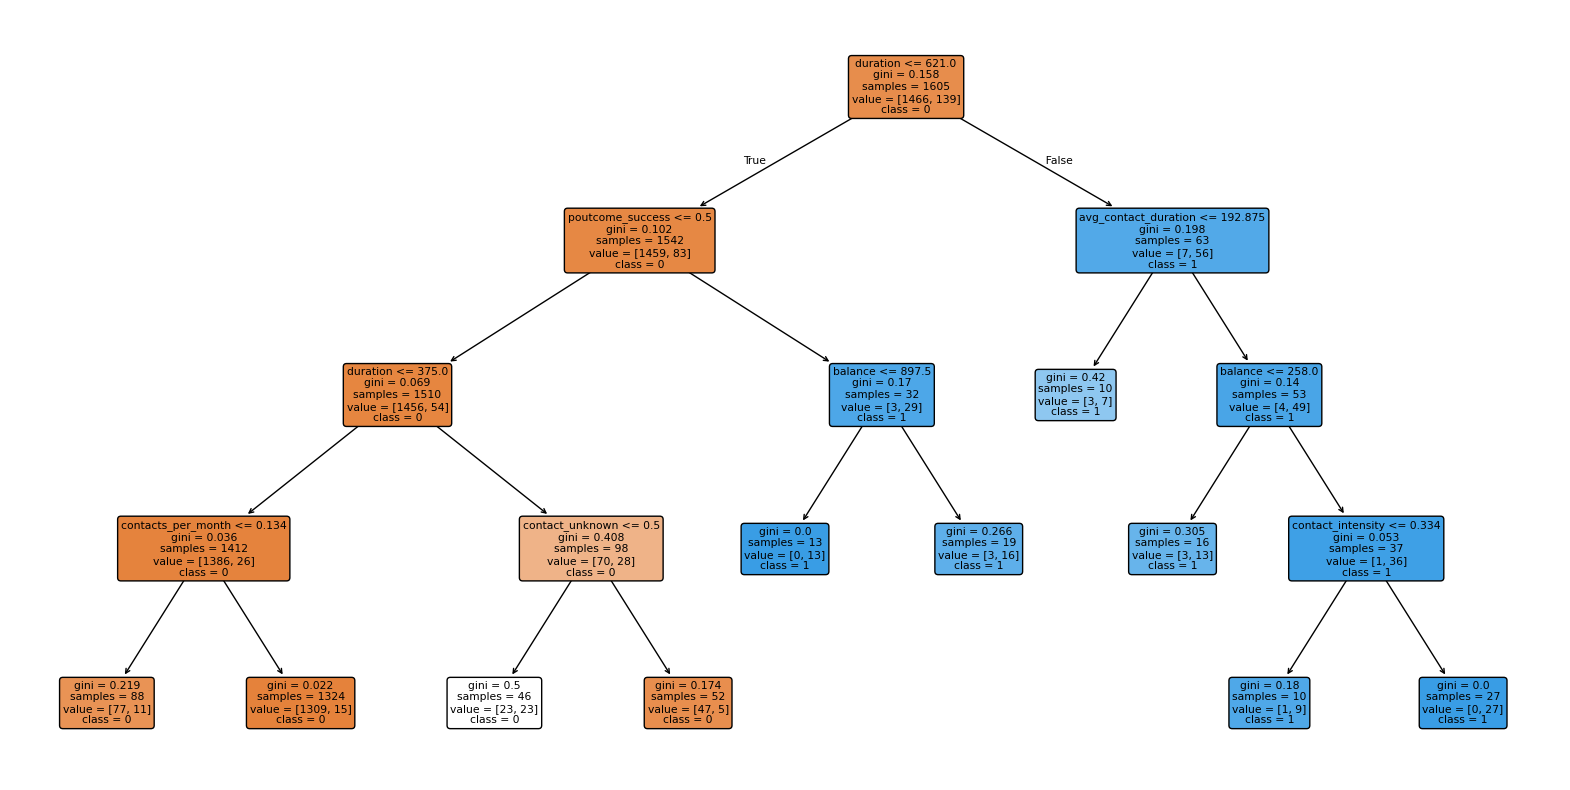

In [ ]:
dt = DecisionTreeClassifier(max_depth=4,
                            min_samples_leaf=10,
                            random_state=42)
dt_cv = cross_validate(dt, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)
print_metrics(dt_cv)
dt.fit(X_train, y_train)

plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=list(X.columns),
          class_names=['0', '1'], rounded=True)
plt.show()

## Balance

### LR experiments

In [31]:
lr = load('models/bank/lr.joblib')

In [ ]:
lr

Pipeline(steps=[('scaler', RobustScaler()),
                ('lr',
                 LogisticRegression(C=np.float64(29.763514416313193),
                                    class_weight={0: 1, 1: 10},
                                    l1_ratio=np.float64(0.2), max_iter=100000,
                                    n_jobs=-1, penalty='elasticnet',
                                    solver='saga'))])

In [ ]:
lr_cv = cross_validate(lr, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(lr_cv)

Train Bacc: 0.92
Train Prec: 0.55
Train Rec: 0.91

Validation Bacc: 0.9
Validation Prec: 0.53
Validation Rec: 0.88


With random undersampling it gets a bit better in recall in exchange of a lot of precision:

In [53]:
lr_us = ImbPipeline ([
    ('us', RandomUnderSampler()),
    ('scaler', lr['scaler']),
    # Same as best one but without class weights
    ('lr', LogisticRegression(C=np.float64(29.763514416313193),
                              l1_ratio=np.float64(0.2), max_iter=100_000, n_jobs=-1,
                              penalty='elasticnet', solver='saga')),
])

lr_us_cv = cross_validate(lr_us, X_train, y_train, cv=kf,
                          scoring=scoring, return_train_score=True)

print_metrics(lr_us_cv)

Train Bacc: 0.92
Train Prec: 0.46
Train Rec: 0.95

Validation Bacc: 0.89
Validation Prec: 0.42
Validation Rec: 0.9


With random oversampling it gets a bit better in precision in exchange of some recall:

In [79]:
lr_os = ImbPipeline ([
    ('us', RandomOverSampler()),
    ('scaler', lr['scaler']),
    # Same as best one but without class weights
    ('lr', LogisticRegression(C=np.float64(29.763514416313193),
                              l1_ratio=np.float64(0.2), max_iter=100_000, n_jobs=-1,
                              penalty='elasticnet', solver='saga')),
])

lr_os_cv = cross_validate(lr_os, X_train, y_train, cv=kf,
                          scoring=scoring, return_train_score=True)

print_metrics(lr_os_cv)

Train Bacc: 0.95
Train Prec: 0.65
Train Rec: 0.96

Validation Bacc: 0.9
Validation Prec: 0.58
Validation Rec: 0.86


Threshold study with balanced accuracy:

In [80]:
y_prob1 = cross_val_predict(lr, X_train, y_train, cv=kf, method='predict_proba')[:, 1]
ths = np.arange(0, 1.1, 0.05)
baccs = []

for th in ths:
    preds = (y_prob1 > th).astype(int)
    bacc = balanced_accuracy_score(y_train, preds)
    baccs.append(bacc)

In [81]:
idx_best = np.argmax(baccs)
ths[idx_best], baccs[idx_best]

(np.float64(0.45), np.float64(0.9092401385849029))

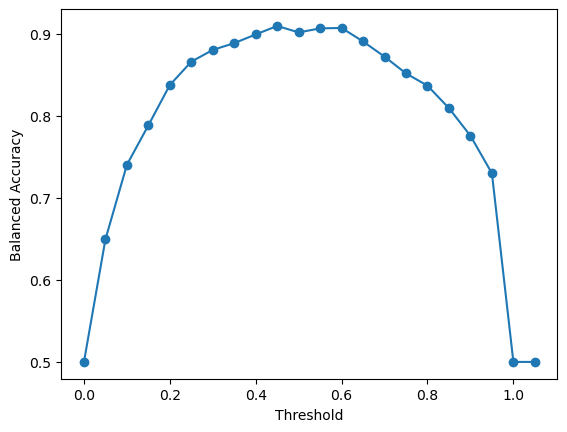

In [82]:
plt.plot(ths, baccs, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.show()

### RF experiments

In [ ]:
# Standard, no class balance

rf = RandomForestClassifier(max_depth=10, n_jobs=-1)
rf_cv = cross_validate(rf, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(rf_cv)

Train Bacc: 0.97
Train Prec: 1.0
Train Rec: 0.94

Validation Bacc: 0.82
Validation Prec: 0.85
Validation Rec: 0.65


In [ ]:
# Class weight

rf = RandomForestClassifier(max_depth=10, class_weight='balanced', n_jobs=-1)
rf_cv = cross_validate(rf, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(rf_cv)

Train Bacc: 1.0
Train Prec: 0.99
Train Rec: 1.0

Validation Bacc: 0.8
Validation Prec: 0.85
Validation Rec: 0.61


In [ ]:
# Random Undersampling

rf_pipe = ImbPipeline([
    ('rus', RandomUnderSampler()),
    ('rf', RandomForestClassifier(max_depth=10, n_jobs=-1)),
])
rf_cv = cross_validate(rf_pipe, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(rf_cv)

Train Bacc: 0.96
Train Prec: 0.58
Train Rec: 1.0

Validation Bacc: 0.91
Validation Prec: 0.53
Validation Rec: 0.91


In [62]:
# Random Oversampling

rf_pipe = ImbPipeline([
    ('ros', RandomOverSampler()),
    ('rf', RandomForestClassifier(max_depth=10, n_jobs=-1)),
])
rf_cv = cross_validate(rf_pipe, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(rf_cv)

Train Bacc: 1.0
Train Prec: 0.99
Train Rec: 1.0

Validation Bacc: 0.86
Validation Prec: 0.82
Validation Rec: 0.73


In [63]:
# SMOTE

rf_pipe = ImbPipeline([
    ('smote', SMOTE()),
    ('rf', RandomForestClassifier(max_depth=10, n_jobs=-1)),
])
rf_cv = cross_validate(rf_pipe, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(rf_cv)

Train Bacc: 1.0
Train Prec: 0.99
Train Rec: 0.99

Validation Bacc: 0.85
Validation Prec: 0.79
Validation Rec: 0.71


### RF class weight

For maximizing balanced accuracy, it looked like undersampling was a good strategy.

In [69]:
rf = ImbPipeline([
    ('rus', RandomUnderSampler()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1)),
])

params = [{
    'rf__n_estimators': [100, 200, 300, 400],
    'rf__max_depth': [2, 3, 5, 10, 20, 30, 50, None],
    'rf__class_weight': [
        'balanced',
        {0: 1, 1: 2},
        {0: 1, 1: 5},
        {0: 1, 1: 10},
        {0: 1, 1: 50},
    ]
}]

rf_rs = RandomizedSearchCV(rf,
                           n_iter=100,
                           param_distributions=params,
                           scoring=scoring,
                           cv=kf,
                           refit='Bacc',
                           return_train_score=True,
                           n_jobs=-1)

rf_rs.fit(X_train, y_train)

print(rf_rs.best_params_)
print()
print_metrics_rs(rf_rs)

{'rf__n_estimators': 400, 'rf__max_depth': 20, 'rf__class_weight': 'balanced'}

Train Bacc: 0.97
Train Prec: 0.58
Train Rec: 1.0

Validation Bacc: 0.92
Validation Prec: 0.53
Validation Rec: 0.91


In [76]:
y_prob1 = cross_val_predict(rf_rs.best_estimator_, X_train, y_train, cv=kf, method='predict_proba')[:, 1]
ths = np.arange(0, 1.1, 0.05)
baccs = []

for th in ths:
    preds = (y_prob1 >= th).astype(int)
    bacc = balanced_accuracy_score(y_train, preds)
    baccs.append(bacc)

In [77]:
idx_best = np.argmax(baccs)
ths[idx_best], baccs[idx_best]

(np.float64(0.45), np.float64(0.9176440566509957))

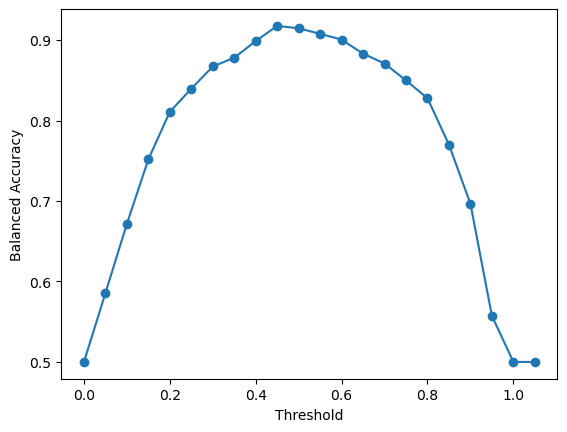

In [78]:
plt.plot(ths, baccs, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.show()

In [71]:
dump(rf_rs.best_estimator_, 'models/bank/rf_ru.joblib')

['models/bank/rf_ru.joblib']

### GB experiments

In [98]:
# Standard, no class balance

gb = HistGradientBoostingClassifier(max_depth=10)
gb_cv = cross_validate(gb, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(gb_cv)

Train Bacc: 1.0
Train Prec: 1.0
Train Rec: 1.0

Validation Bacc: 0.83
Validation Prec: 0.82
Validation Rec: 0.68


In [99]:
# Class weight

gb = HistGradientBoostingClassifier(max_depth=10, class_weight='balanced')
gb_cv = cross_validate(gb, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(gb_cv)

Train Bacc: 1.0
Train Prec: 1.0
Train Rec: 1.0

Validation Bacc: 0.86
Validation Prec: 0.78
Validation Rec: 0.75


In [101]:
# Random Undersampling

gb_pipe = ImbPipeline([
    ('rus', RandomUnderSampler()),
    ('gb', HistGradientBoostingClassifier(max_depth=10)),
])
gb_cv = cross_validate(gb_pipe, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(gb_cv)

Train Bacc: 0.96
Train Prec: 0.52
Train Rec: 1.0

Validation Bacc: 0.9
Validation Prec: 0.49
Validation Rec: 0.9


In [103]:
# Random Oversampling

gb_pipe = ImbPipeline([
    ('ros', RandomOverSampler()),
    ('gb', HistGradientBoostingClassifier(max_depth=10)),
])
gb_cv = cross_validate(gb_pipe, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(gb_cv)

Train Bacc: 1.0
Train Prec: 1.0
Train Rec: 1.0

Validation Bacc: 0.86
Validation Prec: 0.77
Validation Rec: 0.74


In [104]:
# SMOTE

gb_pipe = ImbPipeline([
    ('smote', SMOTE()),
    ('gb', HistGradientBoostingClassifier(max_depth=10)),
])
gb_cv = cross_validate(gb_pipe, X_train, y_train, cv=kf,
                       scoring=scoring, return_train_score=True)

print_metrics(gb_cv)

Train Bacc: 1.0
Train Prec: 1.0
Train Rec: 1.0

Validation Bacc: 0.85
Validation Prec: 0.78
Validation Rec: 0.71


### GB class weight

In [ ]:
# Without understampling

gb = HistGradientBoostingClassifier(loss='log_loss', random_state=42)

params = {
    'learning_rate': np.logspace(-3, 0, 10),
    'min_samples_leaf': [1, 2, 4, 6],
    'max_depth': [3, 4, 5, 6, 8, 10, 20],
    'max_features': np.arange(0.1, 1.1, 0.1),
    'max_leaf_nodes': [None, 5, 10, 20],
    'validation_fraction': [0.1, 0.15, 0.2],
    'class_weight': [
        'balanced',
        {0: 1, 1: 2},
        {0: 1, 1: 5},
        {0: 1, 1: 10},
        {0: 1, 1: 50},
    ]
}

gb_rs = RandomizedSearchCV(gb,
                           n_iter=200,
                           param_distributions=params,
                           scoring=scoring,
                           cv=kf,
                           refit='Bacc',
                           return_train_score=True,
                           n_jobs=-1)

gb_rs.fit(X_train, y_train)

print(gb_rs.best_params_)
print()
print_metrics_rs(gb_rs)

{'validation_fraction': 0.2, 'min_samples_leaf': 6, 'max_leaf_nodes': 10, 'max_features': np.float64(0.2), 'max_depth': 3, 'learning_rate': np.float64(0.1), 'class_weight': {0: 1, 1: 50}}

Train Bacc: 0.97
Train Prec: 0.6
Train Rec: 1.0

Validation Bacc: 0.93
Validation Prec: 0.53
Validation Rec: 0.93


In [ ]:
# With understampling

gb_us = ImbPipeline([
    ('rus', RandomUnderSampler()),
    ('gb', HistGradientBoostingClassifier(loss='log_loss')),
])

params = {
    'gb__learning_rate': np.logspace(-3, 0, 10),
    'gb__min_samples_leaf': [1, 2, 4, 6],
    'gb__max_depth': [3, 4, 5, 6, 8, 10, 20],
    'gb__max_features': np.arange(0.1, 1.1, 0.1),
    'gb__max_leaf_nodes': [None, 5, 10, 20],
    'gb__validation_fraction': [0.1, 0.15, 0.2],
    'gb__class_weight': [
        'balanced',
        {0: 1, 1: 2},
        {0: 1, 1: 5},
        {0: 1, 1: 10},
        {0: 1, 1: 50},
    ]
}

gb_us_rs = RandomizedSearchCV(gb_us,
                           n_iter=200,
                           param_distributions=params,
                           scoring=scoring,
                           cv=kf,
                           refit='Bacc',
                           return_train_score=True,
                           n_jobs=-1)

gb_us_rs.fit(X_train, y_train)

print(gb_us_rs.best_params_)
print()
print_metrics_rs(gb_us_rs)

{'gb__validation_fraction': 0.15, 'gb__min_samples_leaf': 2, 'gb__max_leaf_nodes': 10, 'gb__max_features': np.float64(0.7000000000000001), 'gb__max_depth': 10, 'gb__learning_rate': np.float64(0.21544346900318823), 'gb__class_weight': {0: 1, 1: 2}}

Train Bacc: 0.96
Train Prec: 0.53
Train Rec: 1.0

Validation Bacc: 0.92
Validation Prec: 0.5
Validation Rec: 0.93


#### Round 2

Works better without undersampling and just class weight.

In [ ]:
rs_cv_results(gb_rs)

Bacc: 0.93
Hyperparams: {'validation_fraction': 0.2, 'min_samples_leaf': 6, 'max_leaf_nodes': 10, 'max_features': np.float64(0.2), 'max_depth': 3, 'learning_rate': np.float64(0.1), 'class_weight': {0: 1, 1: 50}}

Bacc: 0.92
Hyperparams: {'validation_fraction': 0.15, 'min_samples_leaf': 4, 'max_leaf_nodes': 10, 'max_features': np.float64(0.1), 'max_depth': 5, 'learning_rate': np.float64(0.046415888336127774), 'class_weight': {0: 1, 1: 50}}

Bacc: 0.92
Hyperparams: {'validation_fraction': 0.15, 'min_samples_leaf': 6, 'max_leaf_nodes': 10, 'max_features': np.float64(0.5), 'max_depth': 3, 'learning_rate': np.float64(0.1), 'class_weight': {0: 1, 1: 50}}

Bacc: 0.91
Hyperparams: {'validation_fraction': 0.2, 'min_samples_leaf': 6, 'max_leaf_nodes': 5, 'max_features': np.float64(0.5), 'max_depth': 4, 'learning_rate': np.float64(0.1), 'class_weight': {0: 1, 1: 50}}

Bacc: 0.91
Hyperparams: {'validation_fraction': 0.1, 'min_samples_leaf': 1, 'max_leaf_nodes': 10, 'max_features': np.float64(0.1),

In [107]:
gb = HistGradientBoostingClassifier(loss='log_loss', random_state=42)

params = {
    'learning_rate': np.logspace(-2, 0, 10),
    'min_samples_leaf': [4, 6, 8, 10],
    'max_depth': [2, 3, 4, 5],
    'max_features': np.arange(0.05, 0.6, 0.05),
    'max_leaf_nodes': [10, 12, 14, 15],
    'validation_fraction': [0.15, 0.18, 0.2],
    'class_weight': [
        'balanced',
        {0: 1, 1: 50},
        {0: 1, 1: 75},
        {0: 1, 1: 100},
        {0: 1, 1: 125},
    ]
}

gb_rs = RandomizedSearchCV(gb,
                           n_iter=200,
                           param_distributions=params,
                           scoring=scoring,
                           cv=kf,
                           refit='Bacc',
                           return_train_score=True,
                           n_jobs=-1)

gb_rs.fit(X_train, y_train)

print(gb_rs.best_params_)
print()
print_metrics_rs(gb_rs)

{'validation_fraction': 0.2, 'min_samples_leaf': 6, 'max_leaf_nodes': 10, 'max_features': np.float64(0.25), 'max_depth': 2, 'learning_rate': np.float64(0.21544346900318834), 'class_weight': {0: 1, 1: 50}}

Train Bacc: 0.97
Train Prec: 0.63
Train Rec: 1.0

Validation Bacc: 0.92
Validation Prec: 0.55
Validation Rec: 0.92


In [ ]:
# The previous model worked better

gb = HistGradientBoostingClassifier(**{
    'validation_fraction': 0.2,
    'min_samples_leaf': 6,
    'max_leaf_nodes': 10,
    'max_features': np.float64(0.2),
    'max_depth': 3,
    'learning_rate': np.float64(0.1),
    'class_weight': {0: 1, 1: 50}
})

dump(gb, 'models/bank/gb.joblib')

### XGB

In [17]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier(n_jobs=-1)

params = {
    'learning_rate': np.logspace(-2, 0, 10),
    'max_depth': [2, 3, 4, 5, 8, 10],
    'min_child_weight': [4, 6, 8, 10, 12],
    'colsample_bytree': np.arange(0.05, 0.6, 0.05),
    'max_leaves': [10, 12, 14, 15, 20],
    'subsample': np.arange(0.5, 1, 0.05),
    'scale_pos_weight': [1, 25, 50, 75, 100, 125]
}

xgb_rs = RandomizedSearchCV(xgb,
                            n_iter=300,
                            param_distributions=params,
                            scoring=scoring,
                            cv=kf,
                            refit='Bacc',
                            return_train_score=True,
                            n_jobs=-1)

xgb_rs.fit(X_train, y_train)

print(xgb_rs.best_params_)
print()
print_metrics_rs(xgb_rs)

{'subsample': np.float64(0.55), 'scale_pos_weight': 25, 'min_child_weight': 10, 'max_leaves': 12, 'max_depth': 10, 'learning_rate': np.float64(0.0774263682681127), 'colsample_bytree': np.float64(0.3)}

Train Bacc: 0.98
Train Prec: 0.72
Train Rec: 1.0

Validation Bacc: 0.93
Validation Prec: 0.66
Validation Rec: 0.9


In [ ]:
xgb_rs.best_estimator_.fit(X_train, y_train)
xgb_ft_imps = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_rs.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False).round(3)

xgb_ft_imps.head(20)

,feature,importance
7,duration,0.292
18,contact_intensity,0.179
19,avg_contact_duration,0.149
40,poutcome_success,0.041
13,month_cos,0.029
9,pdays,0.024
11,month_num,0.022
20,contacts_per_month,0.021
0,age,0.020
3,balance,0.019


In [18]:
dump(xgb_rs.best_estimator_, 'models/bank/xgb.joblib')

['models/bank/xgb.joblib']

### Catboost

Try with raw data.

In [26]:
from catboost import CatBoostClassifier

In [46]:
# Load raw data and prepare a bit
df_raw = pd.read_csv('data/bank_term_deposit/bank_term_deposit.csv')
df_raw = df_raw[df_raw['split'] == 'labeled']
df_raw['y'] = df_raw['y'].map({'no': 0, 'yes': 1})


X_raw_train = df_raw.loc[X_train.index].drop(columns=fts2drop)

# Needed for indicating to CatBoost which columns are categorical
cat_cols = X_raw_train.select_dtypes(include=['object', 'category']).columns
cat_idx = [X_raw_train.columns.get_loc(c) for c in cat_cols]

In [ ]:
cb = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='Logloss',
    random_seed=42,
    verbose=0
)

params = {
    'learning_rate': np.logspace(-2, 0, 10),
    'depth': range(2, 11),
    'l2_leaf_reg': [1, 3, 5, 7, 9, 12],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],
    'border_count': [32, 64, 128, 254],
    'grow_policy': ['SymmetricTree', 'Depthwise'],
    'scale_pos_weight': [1, 50, 75, 100, 125]
}

cb_rs = RandomizedSearchCV(cb,
                           n_iter=10,
                           param_distributions=params,
                           scoring=scoring,
                           cv=kf,
                           refit='Bacc',
                           return_train_score=True,
                           n_jobs=-1)

cb_rs.fit(X_raw_train, y_train, cat_features=cat_idx)

print(cb_rs.best_params_)
print()
print_metrics_rs(cb_rs)

{'subsample': 0.7, 'scale_pos_weight': 125, 'learning_rate': np.float64(0.1291549665014884), 'l2_leaf_reg': 3, 'grow_policy': 'SymmetricTree', 'depth': 9, 'colsample_bylevel': 1.0, 'border_count': 254}

Train Bacc: 0.98
Train Prec: 0.73
Train Rec: 0.99

Validation Bacc: 0.92
Validation Prec: 0.63
Validation Rec: 0.89


### Balanced RF

In [55]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [56]:
brf = BalancedRandomForestClassifier(replacement=True,
                                     random_state=42,
                                     n_jobs=-1)

params = [{
    'sampling_strategy': [0.1, 0.25, 0.5, 0.75, 1, 'not minority', 'all'],
    'n_estimators': [100, 200, 300],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_depth': [5, 10, 30, 50, None],
    'max_samples': [None, 0.5, 0.7, 0.9],
    'max_leaf_nodes': [None, 5, 10, 20],
}]

brf_rs = RandomizedSearchCV(brf,
                           n_iter=200,
                           param_distributions=params,
                           scoring=scoring,
                           cv=kf,
                           refit='Bacc',
                           return_train_score=True)

brf_rs.fit(X_train, y_train)

print(brf_rs.best_params_)
print()
print_metrics_rs(brf_rs)

Exception ignored in: <function ResourceTracker.__del__ at 0x7f7be858d6c0>
Traceback (most recent call last):
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f75987996c0>
Traceback (most recent call last):
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/ibci/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7

{'sampling_strategy': 1, 'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.7, 'max_leaf_nodes': 20, 'max_depth': 30}

Train Bacc: 0.96
Train Prec: 0.57
Train Rec: 0.99

Validation Bacc: 0.92
Validation Prec: 0.53
Validation Rec: 0.92


In [59]:
brf_rs.best_estimator_.fit(X_train, y_train)
brf_ft_imps = pd.DataFrame({
    'feature': X_train.columns,
    'importance': brf_rs.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False).round(3)

brf_ft_imps.head(20)

,feature,importance
7,duration,0.292
18,contact_intensity,0.179
19,avg_contact_duration,0.149
40,poutcome_success,0.041
13,month_cos,0.029
9,pdays,0.024
11,month_num,0.022
20,contacts_per_month,0.021
0,age,0.020
3,balance,0.019


In [58]:
dump(brf_rs.best_estimator_, 'models/bank/brf.joblib')

['models/bank/brf.joblib']

#### Full train study

In [17]:
brf = load('models/bank/brf.joblib')

In [18]:
brf_cv = cross_validate(brf, X_train, y_train, cv=kf,
                        scoring=scoring, return_train_score=True)

print_metrics(brf_cv)

Train Bacc: 0.96
Train Prec: 0.576
Train Rec: 0.989

Validation Bacc: 0.911
Validation Prec: 0.514
Validation Rec: 0.906


In [19]:
brf.fit(X_train, y_train)
# get the probabilities for the positive class in the validation sets
y_val_probs = cross_val_predict(brf, X_train, y_train, cv=kf, method='predict_proba')
y_val_probs_1 = y_val_probs[:, 1]

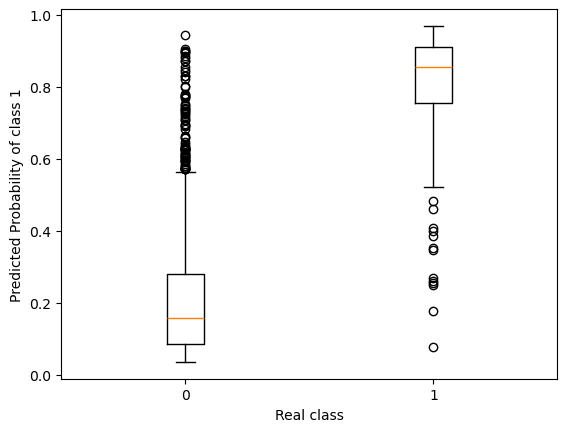

In [20]:
idx0 = np.where(y_train == 0)[0]
idx1 = np.where(y_train == 1)[0]

plt.boxplot([y_val_probs_1[idx0], y_val_probs_1[idx1]], tick_labels=[0, 1])
plt.xlabel('Real class')
plt.ylabel('Predicted Probability of class 1')
plt.show()

In [21]:
# Vary the decision threshold and show Precision and Recall
print('Threshold | B. Acc.    | Recall    | Precision')
print('-----------------------------------------------------')
for th in list(np.arange(0, 1, 0.05)) + [0.9999]:
    bacc = balanced_accuracy_score(y_train, y_val_probs_1 > th)
    rec = recall_score(y_train, y_val_probs_1 > th)
    prec = precision_score(y_train, y_val_probs_1 > th, zero_division=0)
    print(f'{th:.2f} \t  | {prec:.3f}      | {rec:.2f}      | {bacc:.2f}')

Threshold | B. Acc.    | Recall    | Precision
-----------------------------------------------------
0.00 	  | 0.087      | 1.00      | 0.50
0.05 	  | 0.090      | 1.00      | 0.52
0.10 	  | 0.120      | 0.99      | 0.65
0.15 	  | 0.153      | 0.99      | 0.74
0.20 	  | 0.197      | 0.99      | 0.80
0.25 	  | 0.241      | 0.98      | 0.84
0.30 	  | 0.287      | 0.96      | 0.87
0.35 	  | 0.332      | 0.95      | 0.88
0.40 	  | 0.378      | 0.93      | 0.89
0.45 	  | 0.448      | 0.92      | 0.91
0.50 	  | 0.508      | 0.91      | 0.91
0.55 	  | 0.575      | 0.88      | 0.91
0.60 	  | 0.642      | 0.86      | 0.91
0.65 	  | 0.721      | 0.86      | 0.91
0.70 	  | 0.755      | 0.84      | 0.91
0.75 	  | 0.809      | 0.76      | 0.87
0.80 	  | 0.847      | 0.68      | 0.83
0.85 	  | 0.867      | 0.52      | 0.76
0.90 	  | 0.959      | 0.34      | 0.67
0.95 	  | 1.000      | 0.04      | 0.52
1.00 	  | 0.000      | 0.00      | 0.50


In [39]:
# Vary the decision on both class 1 and 0, removing data for which the model is less sure

print(f'{"Threshold":>9} | {"% Data":>7} | {"B. Acc.":>7} | {"Recall":>7} | {"Precision":>9}')
print('-' * 55)

for th in np.arange(0, 0.99, 0.05):
    y_val_ser = pd.Series(y_val_probs_1, index=y_train.index)
    likely_df = y_val_ser[(y_val_ser > th) | (y_val_ser < 1 - th)]
    likely_pred = (likely_df >= 0.5).astype(int)
    likely_y = y_train.loc[likely_df.index]

    perc_data = len(likely_df) / len(y_train)
    bacc = balanced_accuracy_score(likely_y, likely_pred)
    rec = recall_score(likely_y, likely_pred)
    prec = precision_score(likely_y, likely_pred, zero_division=0)

    print(f'{th:9.2f} | {perc_data:7.0%} | {bacc:7.3f} | {rec:7.3f} | {prec:9.3f}')

Threshold |  % Data | B. Acc. |  Recall | Precision
-------------------------------------------------------
     0.00 |    100% |   0.912 |   0.906 |     0.508
     0.05 |    100% |   0.912 |   0.906 |     0.508
     0.10 |    100% |   0.912 |   0.906 |     0.508
     0.15 |    100% |   0.912 |   0.906 |     0.508
     0.20 |    100% |   0.912 |   0.906 |     0.508
     0.25 |    100% |   0.912 |   0.906 |     0.508
     0.30 |    100% |   0.912 |   0.906 |     0.508
     0.35 |    100% |   0.912 |   0.906 |     0.508
     0.40 |    100% |   0.912 |   0.906 |     0.508
     0.45 |    100% |   0.912 |   0.906 |     0.508
     0.50 |    100% |   0.912 |   0.906 |     0.508
     0.55 |     95% |   0.926 |   0.917 |     0.575
     0.60 |     90% |   0.936 |   0.923 |     0.642
     0.65 |     86% |   0.954 |   0.944 |     0.721
     0.70 |     81% |   0.959 |   0.951 |     0.755
     0.75 |     73% |   0.974 |   0.972 |     0.809
     0.80 |     63% |   0.980 |   0.979 |     0.847
     0.8

## Test

In [41]:
models = {
    "LR": load('models/bank/lr.joblib'),
    "GB": load('models/bank/gb.joblib'),
    "XGB": load('models/bank/xgb.joblib'),
    "BRF": load('models/bank/brf.joblib'),
}

In [42]:
thresholds = np.arange(0, 1.01, 0.01)

best_thresholds = {}
test_bal_accs = {}

for name, model in models.items():

    # Validation preds via CV
    val_probs1 = cross_val_predict(
        model, X_train, y_train,
        cv=kf,
        method="predict_proba"
    )[:, 1]

    # Scan thresholds
    best_bacc = -1
    best_th = None

    for th in thresholds:
        preds = (val_probs1 >= th).astype(int)
        bacc = balanced_accuracy_score(y_train, preds)
        if bacc > best_bacc:
            best_bacc = bacc
            best_th = th

    best_thresholds[name] = best_th

    # Retrain model fully
    model.fit(X_train, y_train)

    # Evaluate on test using chosen threshold
    test_probs = model.predict_proba(X_test)[:, 1]
    test_preds = (test_probs >= best_th).astype(int)

    test_bacc = balanced_accuracy_score(y_test, test_preds)
    test_bal_accs[name] = test_bacc

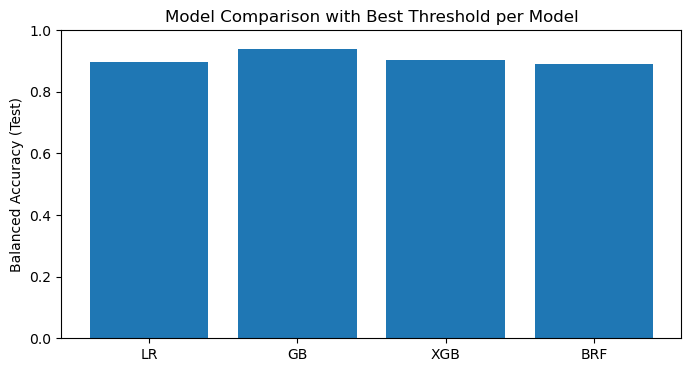

In [43]:
plt.figure(figsize=(8, 4))
plt.bar(test_bal_accs.keys(), test_bal_accs.values())
plt.ylabel("Balanced Accuracy (Test)")
plt.title("Model Comparison with Best Threshold per Model")
plt.ylim(0, 1)
plt.show()

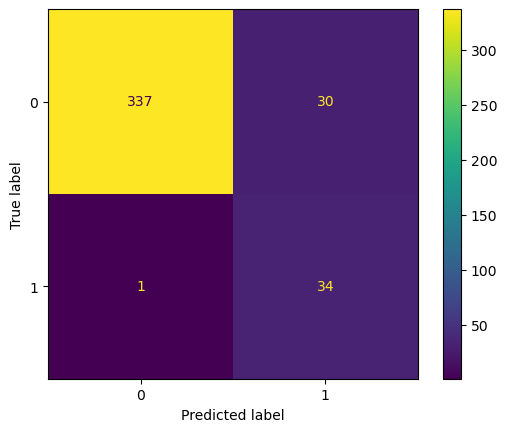

In [44]:
test_probs = models['GB'].predict_proba(X_test)[:, 1]
test_preds = (test_probs >= best_th).astype(int)

cm = confusion_matrix(y_test, test_preds, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0, 1])
disp.plot()
plt.show()

# Submission

In [ ]:
thresholds = np.arange(0, 1.01, 0.01)

# Validation preds via CV
probs1 = cross_val_predict(
    models['GB'], X, y,
    cv=kf,
    method="predict_proba"
)[:, 1]
    
# Scan thresholds
best_bacc = -1
best_th = None

for th in thresholds:
    preds = (probs1 >= th).astype(int)
    bacc = balanced_accuracy_score(y, preds)
    if bacc > best_bacc:
        best_bacc = bacc
        best_th = th


print('Best B. Acc.:', round(best_bacc, 3))
print('Best threshold:', best_th)

Best B. Acc.: 0.925
Best threshold: 0.53


In [ ]:
# The function trains with the whole dataset

create_submission(models['GB'], X, y, leaderboard_df, fts2drop, decision_th=best_th, fpath='final_submission.csv')